In [1]:
from collections import defaultdict
import random
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("ticks")
# sns.set_palette()
colors = sns.color_palette("bright")

import time 
import multiprocessing

from algos import *

In [2]:

manager = multiprocessing.Manager()
error_list = manager.list()

def run_trial(
        i_trial, reward_fn, estimator, num_actions, num_samples, args):
    
    random.seed(10000 + i_trial)
    np.random.seed(10000 + i_trial)
    
    # set action_mus and action_sigmas
    if not args["action_mus"]:
        action_mus = 0.02 * (0.05 - 0.02)*np.random.rand(num_actions)
    else:
        action_mus = args["action_mus"]
        
    action_sigmas = args["action_sigmas"]
        
    # print(action_mus)
    # print(action_sigmas)
    # generate rewards
    action_rewards = reward_fn(
        action_mus, action_sigmas, num_actions, num_samples)
    
    # action_mus_hat = np.mean(action_rewards, axis=0)
    # action_sigmas_hat = np.std(action_rewards, axis=0, ddof=1)
    # print(action_mus_hat)
    # print(action_sigmas_hat)
    
    # apply estimator
    mu_est = estimator(action_rewards, num_actions, num_samples, args)    
    # print(mu_est)

    mu_max = np.max(action_mus)
    # print(mu_max)
    error_list.append(mu_est - mu_max)    

# params
num_actions = 4
num_samples = 100
num_trials = 2000

est_bias_dict = defaultdict(list)
est_var_dict = defaultdict(list)
est_mse_dict = defaultdict(list)

args = dict()
args["weightedms_num_data"] = 1000
args["haver_const"] = 2
args["haver_delta"] = 0.01
    
pool = multiprocessing.Pool()

action_var = 100
haver_const_ary = [0.01, 0.1, 0.5, 1.0, 2.5, 3.0, 5.0, 7.5, 10.0]
action_mu2_ary = np.arange(0, 5.25, 0.25)
action_mus_ary = [[0, 0, -mu, -mu] for mu in action_mu2_ary] 
for haver_const in haver_const_ary:
    start_time = time.time()
    print(f"\n-> haver_const = {haver_const}")
    args["haver_const"] = haver_const
    estimator = create_estimator("haver")
    reward_fn = create_reward_fn("normal")
    
    for action_mus in action_mus_ary:
        args["action_mus"] = action_mus
        args["action_sigmas"] = [np.sqrt(action_var) for i in range(num_actions)]
        num_actions = len(action_mus)
             
        trial_args = [
            (i, reward_fn, estimator, num_actions, num_samples, args) for i in range(num_trials)]
        pool.starmap(run_trial, trial_args)

        error_ary = np.hstack(error_list)
        est_bias = np.mean(error_ary)
        est_var = np.var(error_ary, ddof=1)
        est_mse = est_bias**2 + est_var
        
        est_bias_dict[haver_const].append(est_bias)
        est_var_dict[haver_const].append(est_var)
        est_mse_dict[haver_const].append(est_mse)
                
        error_list[:] = []
        
    end_time = time.time()
    print(f"it takes {end_time-start_time:0.4f}")



-> haver_const = 0.01
it takes 4.0608

-> haver_const = 0.1
it takes 3.9109

-> haver_const = 0.5
it takes 3.9209

-> haver_const = 1.0
it takes 3.9771

-> haver_const = 2.5
it takes 3.9413

-> haver_const = 3.0
it takes 3.9220

-> haver_const = 5.0
it takes 3.9846

-> haver_const = 7.5
it takes 4.0086

-> haver_const = 10.0
it takes 3.9606


In [3]:
est_name_ary = ["weightedms", "double", "max"]
# est_name_ary = ["double", "max"]
# est_name_ary = ["haver"]
action_mu2_ary = np.arange(0, 5.25, 0.25)
action_mus_ary = [[0, 0, -mu, -mu] for mu in action_mu2_ary]
# action_mus_ary = [[0, -10]]
for est_name in est_name_ary:
    start_time = time.time()
    print(f"\n-> est_name = {est_name}")
    estimator = create_estimator(est_name)
    reward_fn = create_reward_fn("normal")
    
    for action_mus in action_mus_ary:
        args["action_mus"] = action_mus
        args["action_sigmas"] = [np.sqrt(action_var) for i in range(num_actions)]
        num_actions = len(action_mus)
             
        trial_args = [
            (i, reward_fn, estimator, num_actions, num_samples, args) for i in range(num_trials)]
        pool.starmap(run_trial, trial_args)

        error_ary = np.hstack(error_list)
        est_bias = np.mean(error_ary)
        est_var = np.var(error_ary, ddof=1)
        est_mse = est_bias**2 + est_var
        
        est_bias_dict[est_name].append(est_bias)
        est_var_dict[est_name].append(est_var)
        est_mse_dict[est_name].append(est_mse)
                
        error_list[:] = []
        
    end_time = time.time()
    print(f"it takes {end_time-start_time:0.4f}")


-> est_name = weightedms
it takes 4.2944

-> est_name = double
it takes 3.9121

-> est_name = max
it takes 3.8506


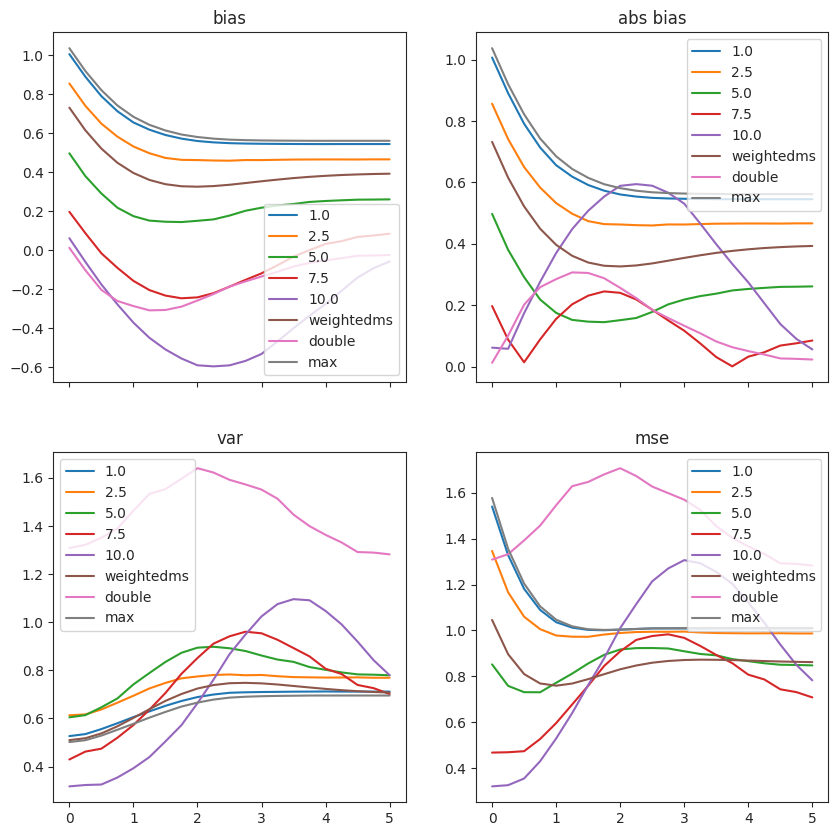

In [4]:
fig, axes = fig, axes = plt.subplots(
        nrows=2, ncols=2, sharex=True, sharey=False, figsize=(10,10))
# axes = [axes]
axes = axes.ravel()

x_ary = action_mu2_ary
haver_const_ary = [1.0, 2.5, 5.0, 7.5, 10.0]
for haver_const in haver_const_ary:
    axes[0].plot(x_ary, est_bias_dict[haver_const], label=haver_const)
    axes[1].plot(x_ary, np.abs(est_bias_dict[haver_const]), label=haver_const)
    axes[2].plot(x_ary, est_var_dict[haver_const], label=haver_const)
    axes[3].plot(x_ary, est_mse_dict[haver_const], label=haver_const)
    
# est_name_ary = ["weightedms", "double", "max"]
for est_name in est_name_ary:
    axes[0].plot(x_ary, est_bias_dict[est_name], label=est_name)
    axes[1].plot(x_ary, np.abs(est_bias_dict[est_name]), label=est_name)
    axes[2].plot(x_ary, est_var_dict[est_name], label=est_name)
    axes[3].plot(x_ary, est_mse_dict[est_name], label=est_name)

axes[0].set_title("bias")
axes[1].set_title("abs bias")
axes[2].set_title("var")
axes[3].set_title("mse")
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.show()